## Setting Imports

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, TimeDistributed, LSTM, MaxPooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence, to_categorical

## Setting Constants and Paths

In [2]:
data_dir = '/kaggle/input/violence-nonviolence-real-life-situations/Real_Life_Violence_Dataset'
CLASS_LIST = ['Violence','NonViolence']
seed = 42
img_height, img_width = 100, 100
batch_size = 8
SEQUENCE_LENGTH = 16

## Data Preprocessing and Dataset Generation

## Creating Dataset first

In [3]:
def extract_frames(video_path):

    frames = []
    video_reader = cv2.VideoCapture(video_path)
    total_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(total_frames//SEQUENCE_LENGTH,1)

    for i in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, i * frame_interval)

        ret,frame = video_reader.read()
        if not ret:
            break

        resized_frame = cv2.resize(frame,(img_height,img_width))

        normalized_frame = resized_frame / 255.0

        frames.append(normalized_frame)

    video_reader.release()

    return frames

def create_dataset(max_vid_per_class = 750):

    features = []
    labels = []
    video_files_paths = []


    for class_index,class_name in enumerate(CLASS_LIST):

        print(f"Extracting Data of Class:{class_name}")

        files_list = os.listdir(os.path.join(data_dir,class_name))

        count = 0
        for filename in files_list:
            if count >= max_vid_per_class:
                break

            video_path = os.path.join(data_dir,class_name,filename)
            frames = extract_frames(video_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_path)
                count += 1

            #print(f"Extraction of {filename} into frames. Completed {count}/{max_vid_per_class}")

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels 

In [4]:
features,labels = create_dataset()

Extracting Data of Class:Violence
Extracting Data of Class:NonViolence


[h264 @ 0x5800448b0c80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5800448b0c80] error while decoding MB 98 31
[h264 @ 0x5800448b0c80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5800448b0c80] error while decoding MB 98 31
[h264 @ 0x5800448b0c80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5800448b0c80] error while decoding MB 98 31
[h264 @ 0x5800448b0c80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x5800448b0c80] error while decoding MB 98 31


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
features_train,features_1,labels_train,labels_1 = train_test_split(features,labels,
                                                                        test_size=0.2,
                                                                        random_state=seed)

In [7]:
features_val,features_test,labels_val,labels_test = train_test_split(features_1,labels_1,
                                                                        test_size=0.3,
                                                                        random_state=seed)

In [8]:
from tensorflow.keras.utils import to_categorical

In [9]:
ohc_labels_train = to_categorical(labels_train)
ohc_labels_val = to_categorical(labels_val)
ohc_labels_test = to_categorical(labels_test)

## Creating the CNN+LSTM Model

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [11]:
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'),
                         input_shape = (SEQUENCE_LENGTH, img_height, img_width, 3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.4)))

model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.4)))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.4)))

model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.4)))

model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Dropout(0.4)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(64,activation='tanh', return_sequences=False))

model.add(Dense(512, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 16, 100, 100,   │           448 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 100, 100,   │            64 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 50, 50, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 50, 50, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 50, 50, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 50, 50, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 25, 25, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 16, 25, 25, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 16, 25, 25, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 16, 25, 25, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 16, 12, 12, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 16, 12, 12, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 16, 12, 12, 64) │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 16, 12, 12, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 16, 6, 6, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 16, 6, 6, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 16, 6, 6, 128)  │        73,85

 Total params: 909,410 (3.47 MB)

 Trainable params: 907,650 (3.46 MB)

 Non-trainable params: 1,760 (6.88 KB)

### Plotting the model

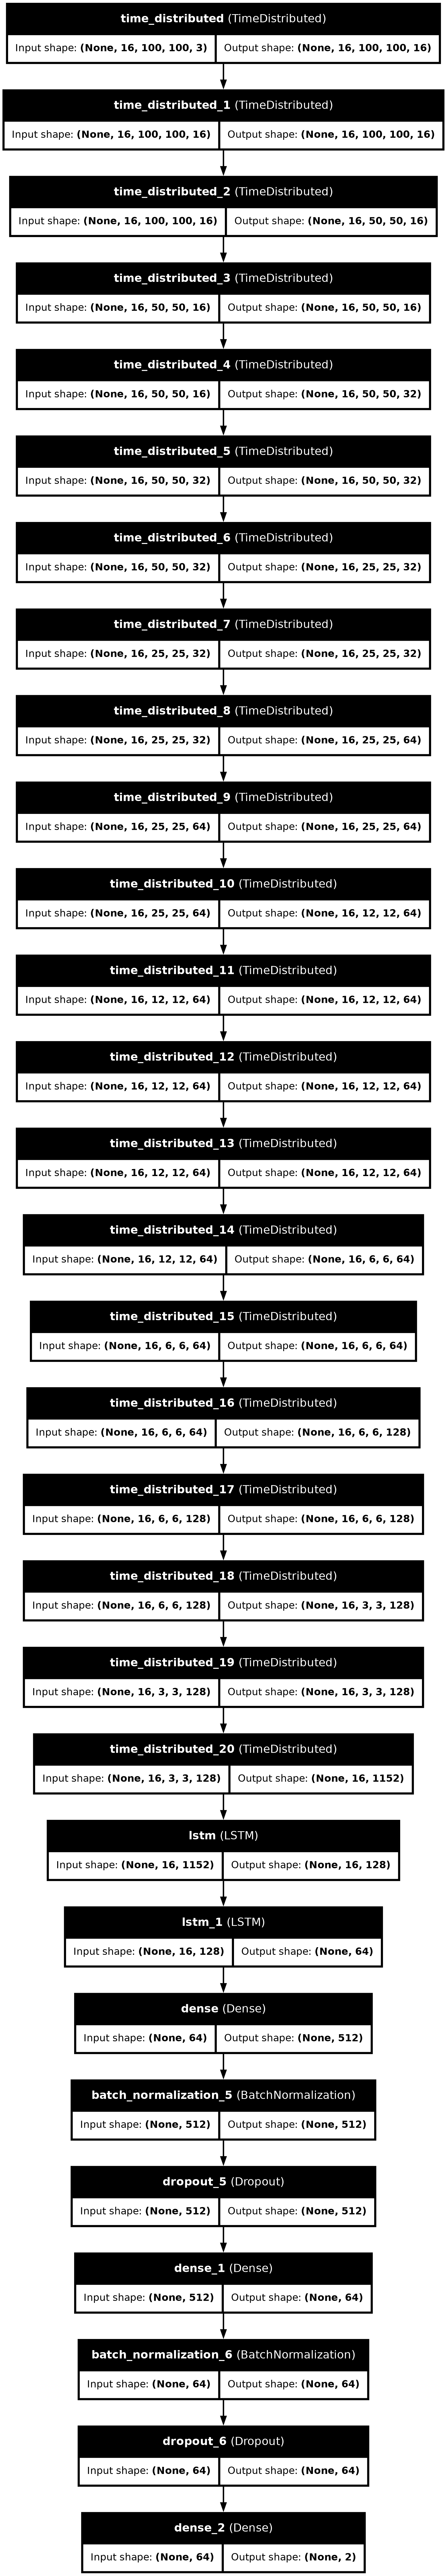

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='CNN+LSTM_model.png', show_shapes=True, show_layer_names=True)

## Setting the Callbacks

In [13]:
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience = 10, 
                                        mode='min', 
                                        restore_best_weights=True)

checkpoint_callback = ModelCheckpoint(
    filepath = 'cnn_lstm.keras',
    save_weights_only = False,
    monitor='val_accuracy',
    mode = 'max',
    save_best_only = True
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',  
                              factor=0.5,          
                              patience=8,          
                              min_lr=0.00001,         
                              verbose=1)


## Training the Model

In [14]:
history = model.fit(x = features_train,
                    y = ohc_labels_train,
                    batch_size = batch_size,
                   epochs = 50,
                   validation_data = (features_val,ohc_labels_val),
                    shuffle=True,
                   callbacks=[early_stopping_callback,checkpoint_callback,reduce_lr])

Epoch 1/50


2024-12-05 08:08:02.941999: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/time_distributed_3_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


150/150 ━━━━━━━━━━━━━━━━━━━━ 56s 180ms/step - accuracy: 0.4748 - loss: 3.3988 - val_accuracy: 0.5286 - val_loss: 2.5919 - learning_rate: 0.0010
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.6018 - loss: 2.6008 - val_accuracy: 0.5143 - val_loss: 2.2974 - learning_rate: 0.0010
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.6303 - loss: 2.2244 - val_accuracy: 0.5286 - val_loss: 2.4950 - learning_rate: 0.0010
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.6249 - loss: 1.9792 - val_accuracy: 0.5286 - val_loss: 2.3783 - learning_rate: 0.0010
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - accuracy: 0.6763 - loss: 1.6679 - val_accuracy: 0.5762 - val_loss: 1.6278 - learning_rate: 0.0010
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 152ms/step - accuracy: 0.7005 - loss: 1.4241 - val_accuracy: 0.6190 - val_loss: 1.4756 - learning_rate: 0.0010
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 22s 149ms/step - accuracy: 0.7269 - loss:

## Plotting the model performance

In [15]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label=metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

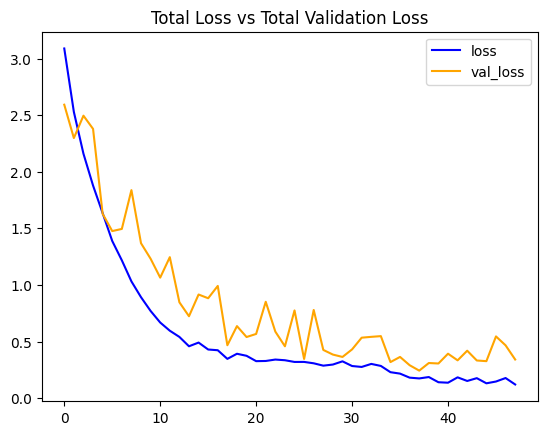

In [16]:
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

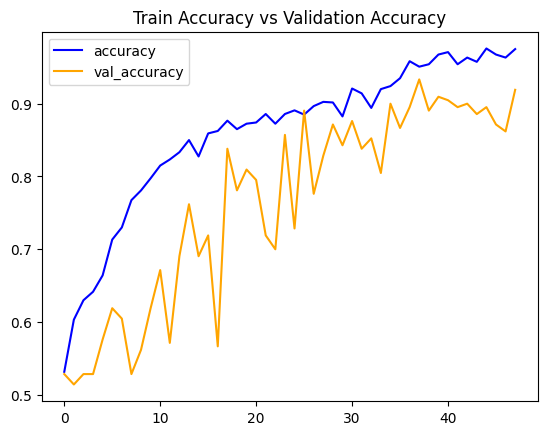

In [17]:
plot_metric(history, 'accuracy', 'val_accuracy', 'Train Accuracy vs Validation Accuracy')

## Testing and Model Evaluation

In [18]:
import time

In [19]:
print("labels_test shape:", labels_test.shape)
print("features_test shape:", features_test.shape)

labels_test shape: (90,)
features_test shape: (90, 16, 100, 100, 3)


In [20]:
start_time = time.perf_counter()
loss, accuracy = model.evaluate(features_test, ohc_labels_test)
end_time = time.perf_counter()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.6f} seconds")
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.8457 - loss: 0.3857
Elapsed time: 0.846390 seconds
Test Loss: 0.4154280424118042
Test Accuracy: 0.855555534362793


In [21]:
labels_predict = model.predict(features_test)
labels_predict = np.argmax(labels_predict, axis=1)
labels_test_normal = np.argmax(ohc_labels_test, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step 


In [22]:
from sklearn.metrics import accuracy_score

AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.8555555555555555


## Confusion Matrix Representation

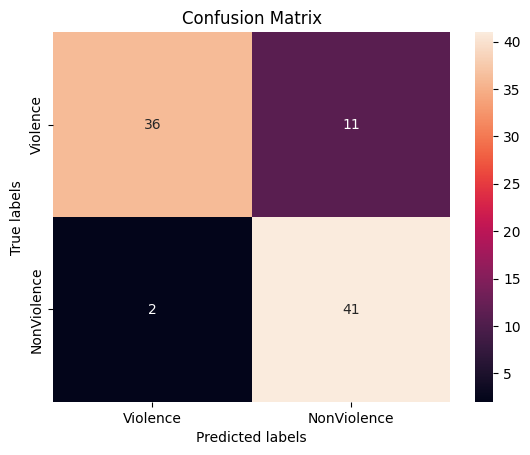

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
cm = confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Violence', 'NonViolence'])
ax.yaxis.set_ticklabels(['Violence', 'NonViolence'])

plt.savefig('/kaggle/working/confusion_matrix.png', format='png', dpi=300, bbox_inches='tight')

plt.show()